In [1]:
import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from utils.mobility_data_manager import DataManager
from utils.common import load_data, Data


SELECTED_DATA= Data.SMALL

In [2]:
df = load_data(SELECTED_DATA)

In [3]:
# Ver las dimensiones del DataFrame (filas y columnas)
print(f"Dimensiones del DataFrame: {df.shape}")

# Ver los nombres de las columnas y sus tipos de datos
print("\nInformación del DataFrame:")
display(df.info())  # display() para mejor presentación en notebooks

# # Mostrar las primeras filas del DataFrame
# print("\nPrimeras filas del DataFrame:")

# # Resumen estadístico de los datos numéricos
print("\nResumen estadístico:")
display(df.describe())

Dimensiones del DataFrame: (992974, 5)

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992974 entries, 0 to 992973
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   uid     992974 non-null  int64
 1   d       992974 non-null  int64
 2   t       992974 non-null  int64
 3   x       992974 non-null  int64
 4   y       992974 non-null  int64
dtypes: int64(5)
memory usage: 37.9 MB


None


Resumen estadístico:


,uid,d,t,x,y
count,992974.000000,992974.000000,992974.000000,992974.000000,992974.000000
mean,99485.453932,35.030088,25.733424,121.482499,84.716833
std,285.532392,22.093950,11.315207,40.754738,43.315214
min,99000.000000,0.000000,0.000000,1.000000,1.000000
25%,99237.000000,16.000000,17.000000,94.000000,58.000000
50%,99477.000000,33.000000,26.000000,125.000000,85.000000
75%,99730.000000,53.000000,35.000000,151.000000,109.000000
max,99999.000000,74.000000,47.000000,200.000000,200.000000


In [4]:
# Configurar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizado: {device}")

Dispositivo utilizado: cpu


In [5]:
def split_data(df):
    """
    Divide los datos en entrenamiento, validación y prueba según el rango de días.
    """
    train = df[df["d"] < 44]  # Días antes de validación
    val = df[
        (df["d"] >= 29) & (df["d"] < 59)
    ]  # Incluye días de entrada y target para validación
    test = df[(df["d"] >= 44)]  # Incluye días de entrada y target para prueba
    return train, val, test


def pad_days_with_template_and_padding(df, timesteps_per_day=48, padding_value=-1):
    """
    Rellena los días incompletos con un valor de padding (-1) para asegurar que cada usuario tenga
    exactamente 48 pings por día.
    """
    padded_days = []

    # Agrupar por usuario y luego por día
    for user in df["uid"].unique():
        user_data = df[df["uid"] == user]
        for day in user_data["d"].unique():
            # Filtrar datos del usuario y día actual
            day_data = user_data[user_data["d"] == day][["t", "x", "y", "t_unified"]]

            # Crear plantilla con todos los timeslots (0 a 47)
            template = pd.DataFrame({"t": range(timesteps_per_day)})
            full_day = pd.merge(template, day_data, on="t", how="left").fillna(
                padding_value
            )

            # Agregar t_unified
            # full_day["t_unified"] = day * timesteps_per_day + full_day["t"]

            # Seleccionar columnas relevantes
            full_day = full_day[["x", "y", "t_unified"]].values

            # Agregar día a la lista
            padded_days.append(full_day)

    return padded_days  # Retorna una lista de matrices [timesteps_per_day, features]


def collate_fn(batch):
    """
    Realiza padding dinámico y genera máscaras para lotes de datos.
    """
    X_batch, y_batch, input_masks, target_masks = zip(*batch)

    # Padding dinámico
    X_batch_padded = pad_sequence(X_batch, batch_first=True, padding_value=-1)
    y_batch_padded = pad_sequence(y_batch, batch_first=True, padding_value=-1)

    # Máscaras combinadas
    input_masks_padded = pad_sequence(input_masks, batch_first=True, padding_value=0)
    target_masks_padded = pad_sequence(target_masks, batch_first=True, padding_value=0)

    return X_batch_padded, y_batch_padded, input_masks_padded, target_masks_padded


def masked_loss_function(preds, targets, mask):
    """
    Calcula la pérdida ignorando los valores con padding.
    """
    # Ajustar la longitud de las predicciones para que coincidan con los targets
    seq_len = targets.shape[1]
    preds = preds[:, :seq_len, :]  # Recortar predicciones

    # Expandir la máscara para cubrir la última dimensión de preds/targets
    mask = mask.unsqueeze(-1).expand_as(targets)

    # Validar dimensiones
    assert (
        preds.shape == targets.shape
    ), f"Preds y targets no coinciden: {preds.shape} vs {targets.shape}"
    assert (
        preds.shape == mask.shape
    ), f"Preds y mask no coinciden: {preds.shape} vs {mask.shape}"

    # Calcular el MSE solo para los valores válidos
    mse_loss = (preds - targets) ** 2
    mse_loss = mse_loss[mask]
    return mse_loss.mean()


def normalize_data(data):
    """
    Normaliza las columnas ['x', 'y', 't', 'd', 't_unified'] en el rango [0, 1].
    """
    scaler = MinMaxScaler()

    # Crear 't_unified' si no existe
    if "t_unified" not in data.columns:
        data["t_unified"] = data["d"] * 48 + data["t"]

    # Seleccionar columnas para normalizar
    columns_to_normalize = ["x", "y", "t_unified"]
    data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

    return data, scaler

In [6]:
class SimpleNNDataset(Dataset):
    """
    Dataset para manejar secuencias basadas en los últimos 15 días con días rellenados con padding.
    """
    def __init__(self, padded_days, seq_days=15, padding_value=-1):
        self.seq_days = seq_days
        self.data = padded_days  # Lista de días [timesteps_per_day, features]
        self.padding_value = padding_value

    def __len__(self):
        return len(self.data) - self.seq_days

    def __getitem__(self, idx):
        # Secuencia de entrada (últimos seq_days días)
        input_days = np.vstack(self.data[idx : idx + self.seq_days])  # Aplanar días
        # Secuencia de predicción (siguientes seq_days días)
        target_days = np.vstack(self.data[idx + self.seq_days : idx + 2 * self.seq_days])  # Aplanar días

        # Crear máscaras para los valores válidos
        input_mask = input_days[:, 0] != self.padding_value  # Máscara para datos válidos
        target_mask = target_days[:, 0] != self.padding_value  # Máscara para datos válidos

        return (
            torch.tensor(input_days, dtype=torch.float32),
            torch.tensor(target_days, dtype=torch.float32),
            torch.tensor(input_mask, dtype=torch.bool),
            torch.tensor(target_mask, dtype=torch.bool),
        )


In [7]:
class SimpleNN(nn.Module):
    """
    Red neuronal para predicción multi-step basada en días.
    """

    def __init__(self, input_size=3, hidden_size=128, output_size=3):
        super(SimpleNN, self).__init__()
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(input_size, hidden_size)  # Primera capa
        self.fc2 = nn.Linear(hidden_size, output_size)  # Salida dinámica

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Aplicar capa oculta
        x = self.fc2(x)  # Salida
        return x  # Mantiene el tamaño dinámico: [batch_size, seq_len, output_size]

In [8]:
train_df, val_df, test_df = split_data(df)
train_df = train_df.copy()
val_df = val_df.copy()
test_df = test_df.copy()

# Normalizar los datos
train_df, train_scaler = normalize_data(train_df)
val_df, val_scaler = normalize_data(val_df)
test_df, test_scaler = normalize_data(test_df)

# Rellenar los días con padding
train_padded = pad_days_with_template_and_padding(train_df)
val_padded = pad_days_with_template_and_padding(val_df)
test_padded = pad_days_with_template_and_padding(test_df)

# Crear los datasets
BATCH_SIZE = 64
train_dataset = SimpleNNDataset(train_padded, seq_days=15)
val_dataset = SimpleNNDataset(val_padded, seq_days=15)
test_dataset = SimpleNNDataset(test_padded, seq_days=15)

# Crear los DataLoaders
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
)

In [9]:
def train_and_validate_model(model, train_loader, val_loader, epochs=20, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses = [], []

    best_val_loss = float("inf")
    best_model_state = None
    best_epoch = -1

    for epoch in range(epochs):
        # Entrenamiento
        model.train()
        train_loss = 0.0
        for X, y, input_mask, target_mask in train_loader:
            X, y, input_mask, target_mask = (
                X.to(device),
                y.to(device),
                input_mask.to(device),
                target_mask.to(device),
            )
            optimizer.zero_grad()
            outputs = model(X)

            # Aplicar máscara en la pérdida
            loss = masked_loss_function(outputs, y, target_mask)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validación
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X, y, input_mask, target_mask in val_loader:
                X, y, input_mask, target_mask = (
                    X.to(device),
                    y.to(device),
                    input_mask.to(device),
                    target_mask.to(device),
                )
                outputs = model(X)
                loss = masked_loss_function(outputs, y, target_mask)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(
            f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )

        # Guardar el mejor modelo
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            best_epoch = epoch + 1  # Guardar la mejor época (1-indexed)

    # Cargar el mejor modelo
    if best_model_state:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses, best_epoch


def evaluate_model(model, data_loader):
    """
    Evalúa el modelo en un conjunto de datos utilizando masked_loss_function.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for X, y, input_mask, target_mask in data_loader:
            X, y, input_mask, target_mask = (
                X.to(device),
                y.to(device),
                input_mask.to(device),
                target_mask.to(device),
            )
            outputs = model(X)
            loss = masked_loss_function(outputs, y, target_mask)  # Usar máscaras
            total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    return avg_loss


import matplotlib.pyplot as plt


def plot_losses(train_losses, val_losses, best_epoch):
    """
    Grafica las pérdidas de entrenamiento y validación.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(
        train_losses,
        label="Training Loss",
    )
    plt.plot(
        val_losses,
        label="Validation Loss",
    )
    plt.axvline(
        best_epoch - 1,
        color="red",
        linestyle="--",
        label=f"Best Model (Epoch {best_epoch})",
    )
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()



In [10]:
# Crear el modelo
EPOCHS = 25
model = SimpleNN(input_size=3, hidden_size=128, output_size=3)

# Entrenar y validar el modelo
criterion = nn.MSELoss()
model, train_losses, val_losses, best_epoch = train_and_validate_model(
    model, train_loader, val_loader, epochs=EPOCHS, lr=0.001
)

Epoch [1/25], Train Loss: 0.0565, Val Loss: 0.0557
Epoch [2/25], Train Loss: 0.0493, Val Loss: 0.0559
Epoch [3/25], Train Loss: 0.0487, Val Loss: 0.0559
Epoch [4/25], Train Loss: 0.0485, Val Loss: 0.0557
Epoch [5/25], Train Loss: 0.0483, Val Loss: 0.0556
Epoch [6/25], Train Loss: 0.0481, Val Loss: 0.0555
Epoch [7/25], Train Loss: 0.0479, Val Loss: 0.0558
Epoch [8/25], Train Loss: 0.0478, Val Loss: 0.0552
Epoch [9/25], Train Loss: 0.0477, Val Loss: 0.0552
Epoch [10/25], Train Loss: 0.0475, Val Loss: 0.0551
Epoch [11/25], Train Loss: 0.0474, Val Loss: 0.0551
Epoch [12/25], Train Loss: 0.0474, Val Loss: 0.0552
Epoch [13/25], Train Loss: 0.0473, Val Loss: 0.0552
Epoch [14/25], Train Loss: 0.0472, Val Loss: 0.0552
Epoch [15/25], Train Loss: 0.0471, Val Loss: 0.0552
Epoch [16/25], Train Loss: 0.0471, Val Loss: 0.0553
Epoch [17/25], Train Loss: 0.0470, Val Loss: 0.0554
Epoch [18/25], Train Loss: 0.0469, Val Loss: 0.0555
Epoch [19/25], Train Loss: 0.0469, Val Loss: 0.0555
Epoch [20/25], Train 

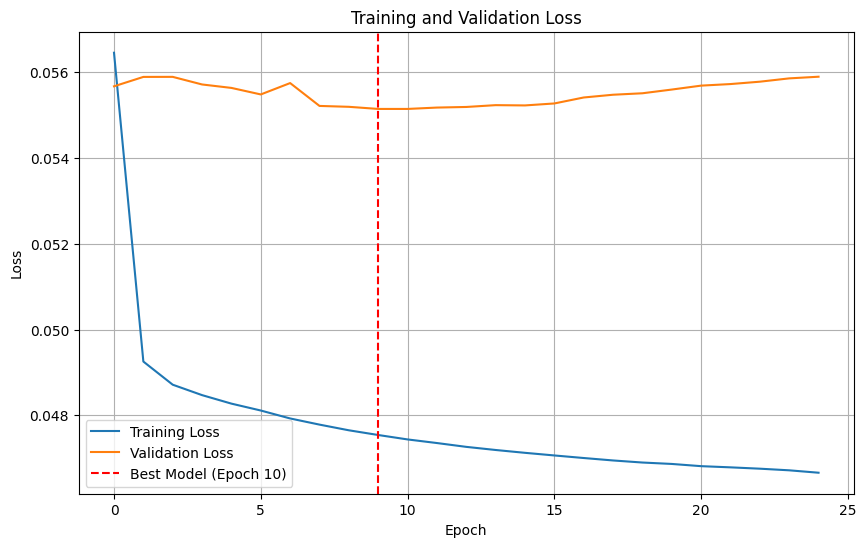

In [11]:
# Graficar las pérdidas
plot_losses(train_losses, val_losses, best_epoch)

In [12]:
# Evaluar en el conjunto de validación
val_loss = evaluate_model(model, val_loader)
print(f"Validation Loss: {val_loss:.4f}")

# Evaluar en el conjunto de prueba
test_loss = evaluate_model(model, test_loader)
print(f"Test Loss: {test_loss:.4f}")

Validation Loss: 0.0559
Test Loss: 0.0642


In [13]:
def plot_user_predictions_by_day(
    model, user_id, df, scaler, seq_days=15, timesteps_per_day=48, days_to_plot=None
):
    """
    Genera y grafica las predicciones y valores reales para un usuario específico, organizados en una cuadrícula.
    Cada gráfico representa un día.

    :param model: Modelo entrenado.
    :param user_id: ID del usuario.
    :param df: DataFrame con los datos.
    :param scaler: Scaler usado para normalizar los datos.
    :param seq_days: Número de días en la secuencia.
    :param timesteps_per_day: Número de timesteps por día.
    :param days_to_plot: Lista de días específicos a graficar (opcional).
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    # Filtrar los datos del usuario
    user_data = df[df["uid"] == user_id].copy()

    # Normalizar los datos
    user_data, _ = normalize_data(user_data)

    # Rellenar los días con padding
    user_data = pad_days_with_template_and_padding(
        user_data, timesteps_per_day=timesteps_per_day
    )

    # Crear dataset del usuario
    dataset = SimpleNNDataset(user_data, seq_days=seq_days)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    # Generar predicciones
    data_by_day = {}
    with torch.no_grad():
        for X, y, _, target_mask in dataloader:
            X, y, target_mask = (
                X.to(device),
                y.to(device),
                target_mask.to(device),
            )
            preds = model(X)

            # Recortar las predicciones para que coincidan con el target
            seq_len = target_mask.shape[1]
            preds = preds[:, :seq_len, :]  # Recortar a la longitud del target

            # Expandir la máscara y filtrar valores válidos
            mask = target_mask.unsqueeze(-1).expand_as(preds)
            preds = preds[mask].view(-1, preds.size(-1)).cpu().numpy()
            y = y[mask].view(-1, y.size(-1)).cpu().numpy()

            # Desnormalizar
            preds = scaler.inverse_transform(preds)
            y = scaler.inverse_transform(y)

            # Obtener día a partir de t_unified
            days = (y[:, 2] // timesteps_per_day).astype(int)
            for day in np.unique(days):
                day_mask = days == day
                if day not in data_by_day:
                    data_by_day[day] = ([], [])
                data_by_day[day][0].append(y[day_mask, :2])  # x, y reales
                data_by_day[day][1].append(preds[day_mask, :2])  # x, y predichos

    # Consolidar los datos por día
    for day in data_by_day:
        data_by_day[day] = (
            np.vstack(data_by_day[day][0]),
            np.vstack(data_by_day[day][1]),
        )

    # Filtrar días a graficar
    days = sorted(data_by_day.keys())
    if days_to_plot is not None:
        days_probe = [day for day in days if day in days_to_plot]
        if len(days_probe) > 0:
            days = days_probe
        else:
            days = days[:10]

    # Configurar la cuadrícula de gráficos
    cols = 5
    rows = (len(days) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))
    axes = axes.flatten()

    # Graficar los datos alineados por día
    for i, day in enumerate(days):
        targets, preds = data_by_day[day]

        # Asegurarse de que hay datos para graficar
        if targets.size == 0 or preds.size == 0:
            continue

        x_targets, y_targets = targets[:, 0], targets[:, 1]
        x_preds, y_preds = preds[:, 0], preds[:, 1]

        ax = axes[i]
        ax.grid(color="gray", linestyle="--", linewidth=0.5)
        ax.plot(
            x_targets, y_targets, label="Real", marker="o", color="blue", markersize=4
        )
        ax.plot(
            x_preds, y_preds, label="Predicho", marker="x", color="orange", markersize=4
        )
        ax.set_title(f"Día {day}")
        ax.set_xlabel("Coordenada X")
        ax.set_ylabel("Coordenada Y")
        ax.legend()

    # Eliminar ejes vacíos si sobran espacios
    for j in range(len(days), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

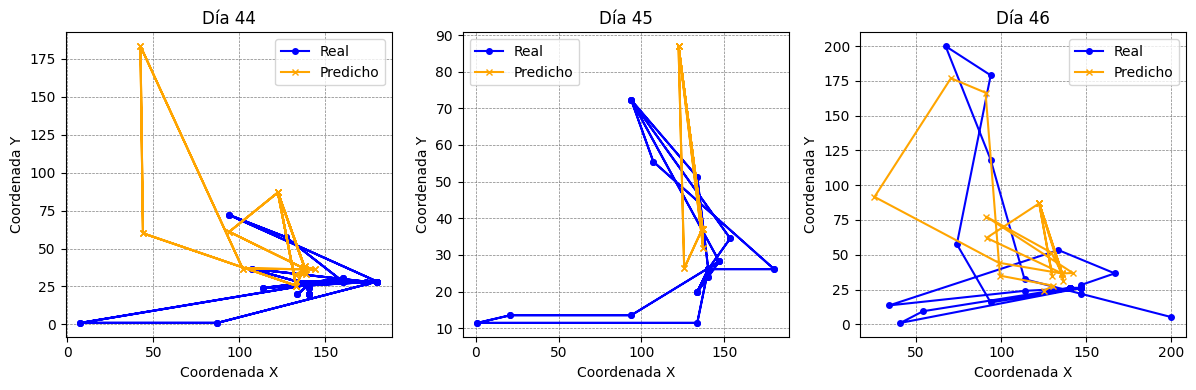

In [14]:
# Graficar las predicciones de un usuario para días específicos
plot_user_predictions_by_day(
    model, user_id=99998, df=test_df, scaler=test_scaler, days_to_plot=[44, 45,46]
)

In [15]:
torch.save(model, "../Data/Models/Simple_NN.pth")
print("Modelo completo guardado correctamente en 'simple_nn_complete.pth'.")

Modelo completo guardado correctamente en 'simple_nn_complete.pth'.


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def calculate_metrics(y_true, y_pred):
    """
    Calcula varias métricas de evaluación para predicciones en problemas de regresión.

    :param y_true: Array de valores reales. Shape: (n_samples, n_features)
    :param y_pred: Array de valores predichos. Shape: (n_samples, n_features)
    :return: Diccionario con métricas calculadas.
    """
    # Asegurarse de que las entradas son numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Validar que las formas coincidan
    if y_true.shape != y_pred.shape:
        raise ValueError("Las dimensiones de y_true y y_pred no coinciden.")

    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(y_true, y_pred)

    # MSE (Mean Squared Error)
    mse = mean_squared_error(y_true, y_pred)

    # RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mse)

    # R² Score
    r2 = r2_score(y_true, y_pred)

    # Distancia Euclidiana Promedio (para coordenadas x, y)
    if y_true.shape[1] >= 2:  # Solo si hay coordenadas en 2D o más
        euclidean_distances = np.sqrt(np.sum((y_true - y_pred) ** 2, axis=1))
        avg_euclidean_distance = np.mean(euclidean_distances)
    else:
        avg_euclidean_distance = None

    # Devuelve las métricas en un diccionario
    metrics = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2,
        "Avg_Euclidean_Distance": avg_euclidean_distance,
    }
    return metrics


In [19]:
def evaluate_and_calculate_metrics(model, data_loader, scaler):
    """
    Evalúa el modelo y calcula métricas de predicción utilizando el conjunto de prueba.

    :param model: Modelo entrenado.
    :param data_loader: DataLoader del conjunto de prueba.
    :param scaler: Scaler usado para desnormalizar los datos.
    :return: Diccionario con métricas calculadas.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_preds = []
    all_targets = []
    with torch.no_grad():
        for X, y, _, target_mask in data_loader:
            X, y, target_mask = (
                X.to(device),
                y.to(device),
                target_mask.to(device),
            )
            preds = model(X)

            # Aplicar máscara para filtrar valores válidos
            mask = target_mask.unsqueeze(-1).expand_as(preds)
            preds = preds[mask].view(-1, preds.size(-1)).cpu().numpy()
            y = y[mask].view(-1, y.size(-1)).cpu().numpy()

            # Desnormalizar
            # preds = scaler.inverse_transform(preds)
            # y = scaler.inverse_transform(y)

            all_preds.append(preds)
            all_targets.append(y)

    # Concatenar todos los datos
    y_pred = np.vstack(all_preds)
    y_true = np.vstack(all_targets)

    # Calcular métricas
    metrics = calculate_metrics(y_true, y_pred)
    return metrics


In [20]:
# Evaluar el modelo en el conjunto de prueba y calcular métricas
test_metrics = evaluate_and_calculate_metrics(model, test_loader, test_scaler)

# Mostrar las métricas calculadas
for metric, value in test_metrics.items():
    print(f"{metric}: {value}")


MAE: 0.19967521727085114
MSE: 0.06443806737661362
RMSE: 0.25384654296762366
R²: -0.030924895778298378
Avg_Euclidean_Distance: 0.4012235105037689
